In [ ]:
from itertools import combinations
import pandas as pd
import numpy as np
from math import *
from decimal import Decimal 
from numpy.linalg import norm
%matplotlib inline
from matplotlib import pyplot as plt
#import os

In [ ]:
#print (os.getcwd())
#os.chdir('D:/OneDrive/ASU/2021 Spring/Applied Project/ASU_Applied_Project_2021/Data')
#print (os.getcwd())

C:\Users\Jinhang Jiang\ASU - Adidas
D:\OneDrive\ASU\2021 Spring\Applied Project\ASU_Applied_Project_2021\Data


In [ ]:
data = pd.read_csv("nw_kor.csv")
data.rename(columns = {'author':'Usernames'}, inplace = True)
view=data.groupby(['Celebrity','Usernames']).size().reset_index(name='Freq')
view
col = ['Celebrity','Usernames']
data = pd.DataFrame(view[col])
data

,Celebrity,Usernames
0,BTS,--hm--
1,BTS,--smesh--
2,BTS,-AgustD
3,BTS,-F0v3r-
4,BTS,-KARAda-
...,...,...
49269,iZone,zx35
49270,iZone,zxcvbnmay
49271,iZone,zxxnxxa
49272,iZone,zyndr0m


In [ ]:
piecount = data.Celebrity.value_counts()
piecount = pd.DataFrame(piecount)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


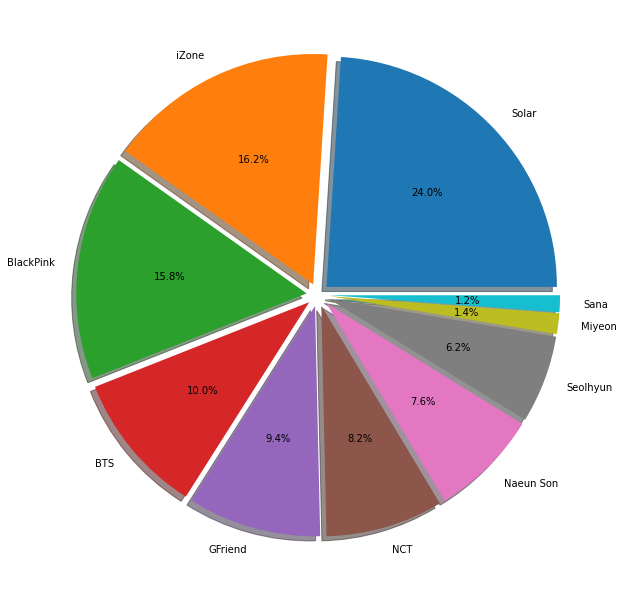

In [ ]:
labels=piecount.index
explode = []
for k in piecount.index:
    explode.append(0.05)
plt.pie(piecount.values, labels=labels, explode=explode, shadow=True, autopct='%1.1f%%')
plt.subplots_adjust(left=2, bottom=2, right=4, top=4)
plt.show()

In [ ]:
# definie class fan_overlap
class fan_overlap:
    
    # Class instantiation, col1 would be node also our target, col2 would be edge  
    def __init__ (self, data, col1, col2):
        self.data = data
        self.Celebrity = data[col1]
        self.Usernames = data[col2]
    
    #find the number of unique celebrities and users
    def unique_obs(self):
        return print("Number of Unique Celebrity:",len(self.Celebrity.unique()),"\n"
                     "Number of Users:",len(self.Usernames),"\n"
                     "Number of Unique Users:",len(self.Usernames.unique()),"\n"
                     "Unique Ratio for Users: {:.2%}".format((len(self.Usernames.unique())/len(self.Usernames))))
    
    #find the frequency table. note: when col = 1, we get frequency table for col1;
    def cel_freq(self, col):
        if col == 1:
            freq = self.Celebrity.value_counts()
        else:
            freq = self.Usernames.value_counts()
        return freq
    
    #find the unique names of Celebrities
    def get_names(self, col):
        if col == 1:
            names = self.Celebrity.unique()
        else:
            names = self.Usernames.unique()
        return names
    
    #find the number of shared fans for any two celebrities
    def overlaps2(self, cel1, cel2):
        l = [cel1,cel2]
        Res = pd.DataFrame(self.data.loc[self.data.iloc[:,0].isin(l)].groupby(self.data.iloc[:,1])[data.columns[0]].nunique().eq(len(l)))
        num_of_overlaps = len(Res[Res.iloc[:,0]==True])
        return int(num_of_overlaps)
    
    #find the number of shared fans for any three celebrities
    def overlaps3(self, cel1, cel2, cel3):
        l = [cel1,cel2, cel3]
        Res = pd.DataFrame(self.data.loc[self.data.iloc[:,0].isin(l)].groupby(self.data.iloc[:,1])[data.columns[0]].nunique().eq(len(l)))
        num_of_overlaps = len(Res[Res.iloc[:,0]==True])
        return int(num_of_overlaps)
    
    #find the number of possible combinations of the nodes(Celebrity), r is the number of nodes in one combination
    def nCr(self, r): 
        n = len(self.Celebrity.unique())
        def fact(n): 
            res = 1
            for i in range(2, n+1): 
                res = res * i 
            return res 
        return print("The Number of Possible Combinations is:",int((fact(n) / (fact(r)* fact(n - r)))))
    
    #generate the cross table of fan base overlap
    def crosstable(self):
        s = pd.crosstab(self.Celebrity,self.Usernames)
        s = s.dot(s.T)
        out = s.mask(np.triu(np.ones(s.shape)).astype(bool)).stack()
        return out
    
    #generate adjacency matrix
    def adjacency_matrix(self):
        #matrix = pd.crosstab(self.Usernames,self.Celebrity)
        df_merge = self.data.merge(self.data, on='Usernames')
        results = pd.crosstab(df_merge.Celebrity_x, df_merge.Celebrity_y)
        np.fill_diagonal(results.values, 0)
        network_table=results
        return network_table
    
    #generate transition matrix
    def transition_matrix(self):
        matrix = pd.crosstab(self.Usernames,self.Celebrity)
        cel_matrix = np.asmatrix(matrix)
        cel_matrix_transpose = cel_matrix.transpose()
        final_matrix = cel_matrix_transpose.dot(cel_matrix)
        transition = final_matrix/final_matrix.sum(axis=0)
        transitionMatrix = transition.T
        TM = pd.DataFrame(transitionMatrix)
        TM.columns = matrix.columns
        TM.index = matrix.columns
        return TM
    
    #generate MCL convergence, get the steady state. The default iteration_count = 20
    def convergence(self):
        #create transition matrix
        matrix = self.crosstable()
        
        p_transition = self.transition_matrix()
        n_states = p_transition.shape[0]
        A = np.append(
            arr=p_transition.T - np.eye(n_states),
            values=np.ones(n_states).reshape(1, -1),
            axis=0
        )
        
        # Moore-Penrose pseudoinverse = (A^TA)^{-1}A^T
        pinv = np.linalg.pinv(A)
        pinv1 = pinv.T[-1]
        #create dictionary for the final results
        test_values= pinv1.tolist()
        test_keys = self.get_names(1)
        convergence_dict = {test_keys[i]: test_values[i] for i in range(len(test_keys))}
        return {key : round(convergence_dict[key], 6) for key in convergence_dict} 
    
    #generate minkowksi distance, r = 1 manhattan, r = 2 euclidean. Default = 2
    def cos_sim(self, x, y):
        neww=pd.crosstab(self.Celebrity,self.Usernames)
        a = neww.loc[x]
        b = neww.loc[y]
        dist = (a @ b.T) / (norm(a)*norm(b))
        return dist
    
    #generate a list of most dissimilar celebrities, default is 3
    def best_complete(self,cel,n = 3):
        cel = cel
        CelebrityDistances = []
        for i in model.get_names(1):
            if i != cel:
                temp = (i,model.cos_sim(cel,i))
                CelebrityDistances.append(tuple(temp))
        def Sort_list_tuples(tup):  
            return(sorted(tup, key = lambda x: x[1]))  
        CelebritySortedDistances = []
        CelebritySortedDistances = Sort_list_tuples(CelebrityDistances)
        CelebrityXNN = ""
        tuple_list = sorted(CelebrityDistances, key=lambda t: t[1], reverse=False)[:n]
        CelebrityXNN = [a_tuple[0] for a_tuple in tuple_list]
        return CelebrityXNN
    
    #generate a list of the most similar celebrities for target,the default is 3
    def best_sub(self,cel,n=3):
        cel = cel
        CelebrityDistances = []
        for i in model.get_names(1):
            if i != cel:
                temp = (i,model.cos_sim(cel,i))
                CelebrityDistances.append(tuple(temp))
        def Sort_list_tuples(tup):  
            return(sorted(tup, key = lambda x: x[1])) 
        CelebritySortedDistances = []
        CelebritySortedDistances = Sort_list_tuples(CelebrityDistances)
        CelebrityXNN = ""
        tuple_list = sorted(CelebrityDistances, key=lambda t: t[1], reverse=True)[:n]
        CelebrityXNN = [a_tuple[0] for a_tuple in tuple_list]
        return CelebrityXNN

In [ ]:
model = fan_overlap(data,"Celebrity","Usernames")

In [ ]:
model.cel_freq(1)

Solar        11827
iZone         7969
BlackPink     7795
BTS           4931
GFriend       4610
NCT           4058
Naeun Son     3751
Seolhyun      3038
Miyeon         713
Sana           582
Name: Celebrity, dtype: int64

In [ ]:
model.get_names(1)

array(['BTS', 'BlackPink', 'GFriend', 'Miyeon', 'NCT', 'Naeun Son',
       'Sana', 'Seolhyun', 'Solar', 'iZone'], dtype=object)

In [ ]:
print(model.overlaps2('Seolhyun','Naeun Son'))
print(model.overlaps2('Miyeon','Naeun Son'))

822
161


In [ ]:
print(model.overlaps3('Naeun Son','BlackPink',"Beyonce"))
print(model.overlaps3('Naeun Son','Beyonce',"Ninjas Hpyer"))

4
0


In [ ]:
model.crosstable()

Celebrity  Celebrity
BlackPink  BTS           689.0
GFriend    BTS           682.0
           BlackPink     924.0
Miyeon     BTS            59.0
           BlackPink     137.0
           GFriend       139.0
NCT        BTS           412.0
           BlackPink     687.0
           GFriend       521.0
           Miyeon          0.0
Naeun Son  BTS           448.0
           BlackPink     640.0
           GFriend       780.0
           Miyeon        161.0
           NCT           402.0
Sana       BTS             8.0
           BlackPink      52.0
           GFriend        26.0
           Miyeon         11.0
           NCT             0.0
           Naeun Son      10.0
Seolhyun   BTS           380.0
           BlackPink     414.0
           GFriend       877.0
           Miyeon        106.0
           NCT           371.0
           Naeun Son     822.0
           Sana           10.0
Solar      BTS           602.0
           BlackPink     674.0
           GFriend      1196.0
           Miyeon 

In [ ]:
model.nCr(2)

The Number of Possible Combinations is: 45


In [ ]:
model.adjacency_matrix()

Celebrity_y,Adriene Mishlder,Ally Love,Bad Bunny,Beyonce,BlackPink,Chinae Alexander,Jerry Lorenzo,Karlie Kloss,Kerwin Frost,Naeun Son,Ninjas Hyper,Pharrell Williams,Yara Shahidi,Zoe Saldana
Celebrity_x,,,,,,,,,,,,,,
Adriene Mishlder,0,3,0,0,2,3,3,3,0,2,0,2,4,2
Ally Love,3,0,41,26,23,21,6,11,4,9,10,7,20,16
Bad Bunny,0,41,0,155,250,63,53,63,70,39,48,134,97,171
Beyonce,0,26,155,0,74,20,2,53,6,11,10,41,30,71
BlackPink,2,23,250,74,0,35,8,22,7,640,18,22,33,44
Chinae Alexander,3,21,63,20,35,0,48,24,6,16,16,9,29,74
Jerry Lorenzo,3,6,53,2,8,48,0,7,30,9,10,24,9,33
Karlie Kloss,3,11,63,53,22,24,7,0,2,6,5,17,29,90
Kerwin Frost,0,4,70,6,7,6,30,2,0,3,4,46,4,6


In [ ]:
model.transition_matrix()
#model.transition_matrix()

Celebrity,Adriene Mishlder,Ally Love,Bad Bunny,Beyonce,BlackPink,Chinae Alexander,Jerry Lorenzo,Karlie Kloss,Kerwin Frost,Naeun Son,Ninjas Hyper,Pharrell Williams,Yara Shahidi,Zoe Saldana
Celebrity,,,,,,,,,,,,,,
Adriene Mishlder,0.724138,0.034483,0.000000,0.000000,0.022989,0.034483,0.034483,0.034483,0.000000,0.022989,0.000000,0.022989,0.045977,0.022989
Ally Love,0.000692,0.954566,0.009456,0.005996,0.005304,0.004843,0.001384,0.002537,0.000923,0.002076,0.002306,0.001614,0.004613,0.003690
Bad Bunny,0.000000,0.002333,0.932620,0.008821,0.014227,0.003585,0.003016,0.003585,0.003984,0.002219,0.002732,0.007626,0.005520,0.009731
Beyonce,0.000000,0.004626,0.027580,0.911210,0.013167,0.003559,0.000356,0.009431,0.001068,0.001957,0.001779,0.007295,0.005338,0.012633
BlackPink,0.000223,0.002563,0.027861,0.008247,0.868717,0.003901,0.000892,0.002452,0.000780,0.071325,0.002006,0.002452,0.003678,0.004904
Chinae Alexander,0.000453,0.003169,0.009508,0.003018,0.005282,0.945065,0.007244,0.003622,0.000906,0.002415,0.002415,0.001358,0.004377,0.011168
Jerry Lorenzo,0.000966,0.001931,0.017058,0.000644,0.002575,0.015449,0.922111,0.002253,0.009656,0.002897,0.003219,0.007724,0.002897,0.010621
Karlie Kloss,0.001090,0.003997,0.022892,0.019259,0.007994,0.008721,0.002544,0.879360,0.000727,0.002180,0.001817,0.006177,0.010538,0.032703
Kerwin Frost,0.000000,0.002011,0.035194,0.003017,0.003519,0.003017,0.015083,0.001006,0.905480,0.001508,0.002011,0.023127,0.002011,0.003017


In [ ]:
model.convergence()

{'Adriene Mishlder': 0.001257,
 'Ally Love': 0.062654,
 'Bad Bunny': 0.253909,
 'Beyonce': 0.081207,
 'BlackPink': 0.129656,
 'Chinae Alexander': 0.095743,
 'Jerry Lorenzo': 0.044895,
 'Karlie Kloss': 0.039765,
 'Kerwin Frost': 0.02874,
 'Naeun Son': 0.065298,
 'Ninjas Hyper': 0.053666,
 'Pharrell Williams': 0.023611,
 'Yara Shahidi': 0.024593,
 'Zoe Saldana': 0.095006}

In [ ]:
%%time
model.best_sub("Naeun Son",n=5)

CPU times: user 1min 20s, sys: 6.34 s, total: 1min 26s
Wall time: 1min 17s


['Seolhyun', 'GFriend', 'iZone', 'Solar', 'BlackPink']

In [ ]:
%%time
model.best_complete("Naeun Son",n=3) #most dissimilar

CPU times: user 1min 20s, sys: 6.69 s, total: 1min 27s
Wall time: 1min 18s


['Sana', 'Miyeon', 'NCT']

In [ ]:
%%time
model.best_sub("BlackPink",n=5)

CPU times: user 1min 19s, sys: 6.15 s, total: 1min 25s
Wall time: 1min 16s


['GFriend', 'NCT', 'Naeun Son', 'BTS', 'Seolhyun']

In [ ]:
%%time
model.best_complete("BlackPink",n=5) 

CPU times: user 1min 20s, sys: 6.53 s, total: 1min 26s
Wall time: 1min 17s


['Sana', 'Miyeon', 'Solar', 'iZone', 'Seolhyun']

In [ ]:
CelebrityDistances = []
target_cel = 'Naeun Son'
for i in model.get_names(1):
    if i != target_cel:
        temp = (i,model.cos_sim(target_cel,i))
        CelebrityDistances.append(tuple(temp))
CelebrityDistances

[('Adriene Mishlder', 0.004114207474558367),
 ('Ally Love', 0.0022841323470378975),
 ('Bad Bunny', 0.0049742555973288916),
 ('Beyonce', 0.002509815315634955),
 ('BlackPink', 0.11835820828188935),
 ('Chinae Alexander', 0.003301337453279962),
 ('Jerry Lorenzo', 0.0027454065419324227),
 ('Karlie Kloss', 0.0019914528815764432),
 ('Kerwin Frost', 0.0011542260352674712),
 ('Ninjas Hyper', 0.0021913858405805927),
 ('Pharrell Williams', 0.0022872401093387883),
 ('Yara Shahidi', 0.004932276229645616),
 ('Zoe Saldana', 0.001908277943825836)]